In [1]:
import pandas as pd
from datasets import load_dataset, Dataset, DatasetDict

reddit_df = pd.read_csv('the-reddit-dataset-dataset-comments.csv')
reddit_df = reddit_df.dropna(subset=['body', 'sentiment'])
reddit_df['body'] = reddit_df['body'].astype(str)
reddit_df['sentiment'] = reddit_df['sentiment'].astype(float)
def assign_label(score):
    if score < -0.5:
        return 0  # Negative
    elif -0.5 <= score <= 0.5:
        return 1  # Neutral
    else:
        return 2  # Positive

reddit_df['text'] = reddit_df['body']
reddit_df['label'] = reddit_df['sentiment'].apply(assign_label)
reddit_df = reddit_df[['text', 'label']]
reddit_data = Dataset.from_pandas(reddit_df)


reddit_dataset = DatasetDict({
    'test': reddit_data
})

In [3]:

from sklearn.model_selection import train_test_split
# Load the CSV file into a pandas DataFrame
df = pd.read_csv('all_sampled_twitter.csv')

# Split the DataFrame into train, validation, and test sets
train_df, temp_df = train_test_split(df, test_size=0.4, random_state=42)
val_df, test_df = train_test_split(temp_df, test_size=0.5, random_state=42)



In [4]:
train_dataset = Dataset.from_pandas(train_df)
val_dataset = Dataset.from_pandas(val_df)
test_dataset = Dataset.from_pandas(test_df)

# Create a DatasetDict
dataset_dict = DatasetDict({
    'train': train_dataset,
    'validation': val_dataset,
    'test': test_dataset
})

In [5]:
dataset_dict

DatasetDict({
    train: Dataset({
        features: ['text', 'label', '__index_level_0__'],
        num_rows: 5246
    })
    validation: Dataset({
        features: ['text', 'label', '__index_level_0__'],
        num_rows: 1749
    })
    test: Dataset({
        features: ['text', 'label', '__index_level_0__'],
        num_rows: 1749
    })
})

In [6]:
from transformers import GPT2Tokenizer, GPT2ForSequenceClassification, DataCollatorWithPadding, TrainingArguments, Trainer
import torch

model_checkpoint = './sentiment-gpt2-2'
tokenizer = GPT2Tokenizer.from_pretrained(model_checkpoint)
tokenizer.pad_token = tokenizer.eos_token

In [7]:
def preprocess_function(examples):
    tokenized = tokenizer(
        examples['text'],
        truncation=True,
        padding="max_length",
        max_length=128
    )
    tokenized["labels"] = examples["label"]
    return tokenized

tokenized_datasets = dataset_dict.map(preprocess_function, batched=True)


Map:   0%|          | 0/5246 [00:00<?, ? examples/s]

Map:   0%|          | 0/1749 [00:00<?, ? examples/s]

Map:   0%|          | 0/1749 [00:00<?, ? examples/s]

In [8]:

model = GPT2ForSequenceClassification.from_pretrained(model_checkpoint, num_labels=3)
model.config.pad_token_id = tokenizer.pad_token_id

In [9]:
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

In [10]:

training_args = TrainingArguments(
    output_dir='./results',
    evaluation_strategy='epoch',
    learning_rate=2e-5,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    num_train_epochs=3,
    weight_decay=0.01,
    logging_dir='./logs',
    logging_steps=10,
)

# Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_datasets['train'],
    eval_dataset=tokenized_datasets['validation'],
    tokenizer=tokenizer,
    data_collator=data_collator,
)


/Users/srinathsureshkumar/miniconda3/envs/bda/lib/python3.12/site-packages/transformers/training_args.py:1559: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
/var/folders/_v/9p5rkkbj79d0bmthxllw7rqm0000gn/T/ipykernel_70771/160643954.py:14: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


  0%|          | 0/219 [00:00<?, ?it/s]

Tweet Accuracy: 0.7501429388221841
Tweet Precision: 0.7651695680221285
Tweet Recall: 0.7584665780811354
Tweet F1 Score: 0.7455220403789472
Tweet Accuracy: 0.7501429388221841


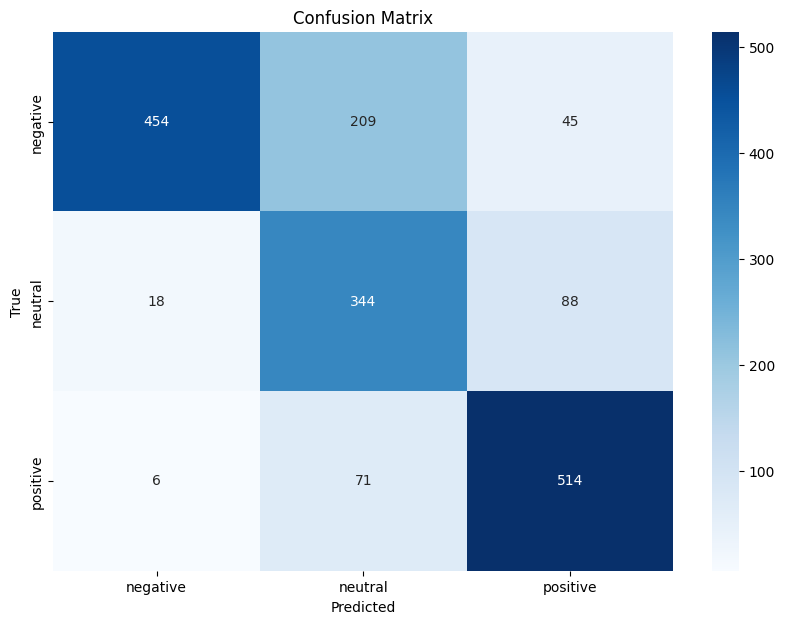

In [11]:
predictions = trainer.predict(tokenized_datasets['test'])
predicted_labels = torch.argmax(torch.tensor(predictions.predictions), dim=1)

from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, confusion_matrix
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt


accuracy = accuracy_score(tokenized_datasets['test']['label'], predicted_labels)
precision = precision_score(tokenized_datasets['test']['label'], predicted_labels, average='macro')
recall = recall_score(tokenized_datasets['test']['label'], predicted_labels, average='macro')
f1_score_ = f1_score(tokenized_datasets['test']['label'], predicted_labels, average='macro')

print(f'Tweet Accuracy: {accuracy}')
print(f'Tweet Precision: {precision}')
print(f'Tweet Recall: {recall}')
print(f'Tweet F1 Score: {f1_score_}')
print(f'Tweet Accuracy: {accuracy}')

conf_matrix = confusion_matrix(tokenized_datasets['test']['labels'], predicted_labels)

plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['negative', 'neutral', 'positive'], yticklabels=['negative', 'neutral', 'positive'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

In [12]:
trainer.train()

  0%|          | 0/1968 [00:00<?, ?it/s]

{'loss': 0.56, 'grad_norm': 18.514238357543945, 'learning_rate': 1.989837398373984e-05, 'epoch': 0.02}
{'loss': 0.6469, 'grad_norm': 23.276262283325195, 'learning_rate': 1.9796747967479675e-05, 'epoch': 0.03}
{'loss': 0.5595, 'grad_norm': 22.711009979248047, 'learning_rate': 1.9695121951219512e-05, 'epoch': 0.05}
{'loss': 0.5457, 'grad_norm': 14.27566909790039, 'learning_rate': 1.959349593495935e-05, 'epoch': 0.06}
{'loss': 0.4416, 'grad_norm': 16.181434631347656, 'learning_rate': 1.949186991869919e-05, 'epoch': 0.08}
{'loss': 0.657, 'grad_norm': 35.62565994262695, 'learning_rate': 1.9390243902439026e-05, 'epoch': 0.09}
{'loss': 0.4875, 'grad_norm': 2.2209320068359375, 'learning_rate': 1.9288617886178863e-05, 'epoch': 0.11}
{'loss': 0.5908, 'grad_norm': 2.60404634475708, 'learning_rate': 1.91869918699187e-05, 'epoch': 0.12}
{'loss': 0.43, 'grad_norm': 12.692609786987305, 'learning_rate': 1.9085365853658537e-05, 'epoch': 0.14}
{'loss': 0.4823, 'grad_norm': 7.0627336502075195, 'learning_

  0%|          | 0/219 [00:00<?, ?it/s]

{'eval_loss': 0.41563692688941956, 'eval_model_preparation_time': 0.0009, 'eval_runtime': 18.1671, 'eval_samples_per_second': 96.273, 'eval_steps_per_second': 12.055, 'epoch': 1.0}
{'loss': 0.4485, 'grad_norm': 14.816426277160645, 'learning_rate': 1.329268292682927e-05, 'epoch': 1.01}
{'loss': 0.4833, 'grad_norm': 27.135969161987305, 'learning_rate': 1.3191056910569107e-05, 'epoch': 1.02}
{'loss': 0.1326, 'grad_norm': 5.523897171020508, 'learning_rate': 1.3089430894308943e-05, 'epoch': 1.04}
{'loss': 0.3137, 'grad_norm': 18.647769927978516, 'learning_rate': 1.2987804878048782e-05, 'epoch': 1.05}
{'loss': 0.2642, 'grad_norm': 21.592077255249023, 'learning_rate': 1.2886178861788619e-05, 'epoch': 1.07}
{'loss': 0.3732, 'grad_norm': 40.56724166870117, 'learning_rate': 1.2784552845528457e-05, 'epoch': 1.08}
{'loss': 0.1918, 'grad_norm': 17.414552688598633, 'learning_rate': 1.2682926829268294e-05, 'epoch': 1.1}
{'loss': 0.296, 'grad_norm': 2.779433488845825, 'learning_rate': 1.25813008130081

  0%|          | 0/219 [00:00<?, ?it/s]

{'eval_loss': 0.49883538484573364, 'eval_model_preparation_time': 0.0009, 'eval_runtime': 18.3432, 'eval_samples_per_second': 95.349, 'eval_steps_per_second': 11.939, 'epoch': 2.0}
{'loss': 0.2173, 'grad_norm': 9.227575302124023, 'learning_rate': 6.585365853658538e-06, 'epoch': 2.01}
{'loss': 0.2512, 'grad_norm': 17.69123077392578, 'learning_rate': 6.483739837398374e-06, 'epoch': 2.03}
{'loss': 0.1589, 'grad_norm': 9.07698917388916, 'learning_rate': 6.3821138211382115e-06, 'epoch': 2.04}
{'loss': 0.2396, 'grad_norm': 4.620939254760742, 'learning_rate': 6.280487804878049e-06, 'epoch': 2.06}
{'loss': 0.2484, 'grad_norm': 6.167441368103027, 'learning_rate': 6.178861788617887e-06, 'epoch': 2.07}
{'loss': 0.1854, 'grad_norm': 2.2459611892700195, 'learning_rate': 6.077235772357724e-06, 'epoch': 2.09}
{'loss': 0.2084, 'grad_norm': 10.986719131469727, 'learning_rate': 5.9756097560975615e-06, 'epoch': 2.1}
{'loss': 0.2932, 'grad_norm': 17.38262939453125, 'learning_rate': 5.873983739837399e-06, 

  0%|          | 0/219 [00:00<?, ?it/s]

{'eval_loss': 0.5799921154975891, 'eval_model_preparation_time': 0.0009, 'eval_runtime': 18.3701, 'eval_samples_per_second': 95.209, 'eval_steps_per_second': 11.922, 'epoch': 3.0}
{'train_runtime': 718.4487, 'train_samples_per_second': 21.906, 'train_steps_per_second': 2.739, 'train_loss': 0.3440863993776038, 'epoch': 3.0}


TrainOutput(global_step=1968, training_loss=0.3440863993776038, metrics={'train_runtime': 718.4487, 'train_samples_per_second': 21.906, 'train_steps_per_second': 2.739, 'total_flos': 1028081347854336.0, 'train_loss': 0.3440863993776038, 'epoch': 3.0})

In [13]:

trainer.evaluate()

  0%|          | 0/219 [00:00<?, ?it/s]

{'eval_loss': 0.5799921154975891,
 'eval_model_preparation_time': 0.0009,
 'eval_runtime': 18.3281,
 'eval_samples_per_second': 95.427,
 'eval_steps_per_second': 11.949,
 'epoch': 3.0}

In [14]:

model.save_pretrained('./finetuned_gpt2_sentiment_neologism')
tokenizer.save_pretrained('./finetuned_gpt2_sentiment_neologism')

('./finetuned_gpt2_sentiment_neologism/tokenizer_config.json',
 './finetuned_gpt2_sentiment_neologism/special_tokens_map.json',
 './finetuned_gpt2_sentiment_neologism/vocab.json',
 './finetuned_gpt2_sentiment_neologism/merges.txt',
 './finetuned_gpt2_sentiment_neologism/added_tokens.json')

  0%|          | 0/219 [00:00<?, ?it/s]

Tweet Accuracy: 0.8359062321326473
Tweet Precision: 0.8302756064771867
Tweet Recall: 0.8147272489731407
Tweet F1 Score: 0.8185201764313904
Tweet Accuracy: 0.8359062321326473


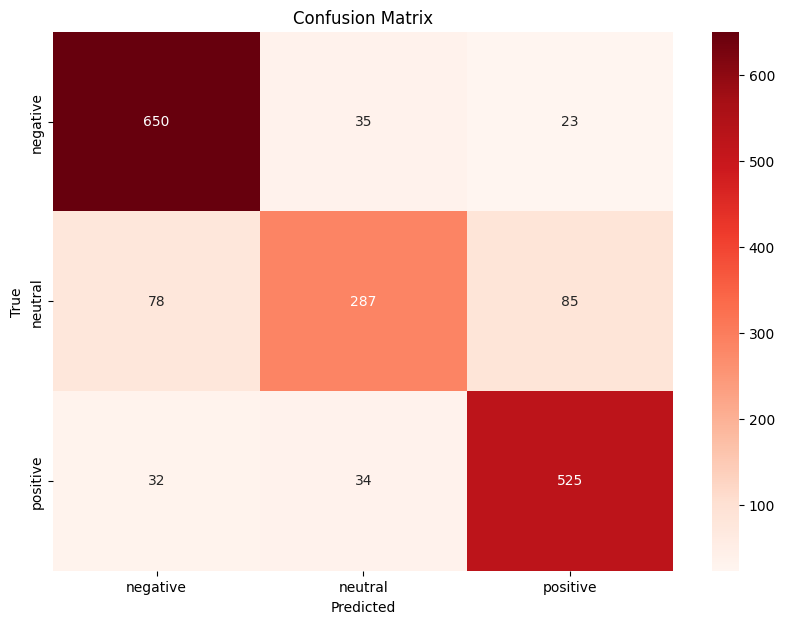

In [15]:
predictions = trainer.predict(tokenized_datasets['test'])
predicted_labels = torch.argmax(torch.tensor(predictions.predictions), dim=1)
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

accuracy = accuracy_score(tokenized_datasets['test']['label'], predicted_labels)
precision = precision_score(tokenized_datasets['test']['label'], predicted_labels, average='macro')
recall = recall_score(tokenized_datasets['test']['label'], predicted_labels, average='macro')
f1_score_ = f1_score(tokenized_datasets['test']['label'], predicted_labels, average='macro')

print(f'Tweet Accuracy: {accuracy}')
print(f'Tweet Precision: {precision}')
print(f'Tweet Recall: {recall}')
print(f'Tweet F1 Score: {f1_score_}')
print(f'Tweet Accuracy: {accuracy}')

conf_matrix = confusion_matrix(tokenized_datasets['test']['labels'], predicted_labels)

plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Reds', xticklabels=['negative', 'neutral', 'positive'], yticklabels=['negative', 'neutral', 'positive'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

In [16]:
model.push_to_hub('srinathsk18/finetuned-gpt-2-sentiment-analysis-neologism')

model.safetensors:   0%|          | 0.00/498M [00:00<?, ?B/s]

CommitInfo(commit_url='https://huggingface.co/srinathsk18/finetuned-gpt-2-sentiment-analysis-neologism/commit/614e84ad276415d38d236475e2ea8ff59a8a1008', commit_message='Upload GPT2ForSequenceClassification', commit_description='', oid='614e84ad276415d38d236475e2ea8ff59a8a1008', pr_url=None, repo_url=RepoUrl('https://huggingface.co/srinathsk18/finetuned-gpt-2-sentiment-analysis-neologism', endpoint='https://huggingface.co', repo_type='model', repo_id='srinathsk18/finetuned-gpt-2-sentiment-analysis-neologism'), pr_revision=None, pr_num=None)

In [17]:
tokenizer.push_to_hub('srinathsk18/finetuned-gpt-2-sentiment-analysis-neologism')

No files have been modified since last commit. Skipping to prevent empty commit.


CommitInfo(commit_url='https://huggingface.co/srinathsk18/finetuned-gpt-2-sentiment-analysis-neologism/commit/614e84ad276415d38d236475e2ea8ff59a8a1008', commit_message='Upload tokenizer', commit_description='', oid='614e84ad276415d38d236475e2ea8ff59a8a1008', pr_url=None, repo_url=RepoUrl('https://huggingface.co/srinathsk18/finetuned-gpt-2-sentiment-analysis-neologism', endpoint='https://huggingface.co', repo_type='model', repo_id='srinathsk18/finetuned-gpt-2-sentiment-analysis-neologism'), pr_revision=None, pr_num=None)

In [ ]:
reddit_tokenized_datasets = reddit_dataset.map(preprocess_function, batched=True)
predictions = trainer.predict(reddit_tokenized_datasets['test'])
predicted_labels = torch.argmax(torch.tensor(predictions.predictions), dim=1)

accuracy = accuracy_score(reddit_tokenized_datasets['test']['label'], predicted_labels)
precision = precision_score(reddit_tokenized_datasets['test']['label'], predicted_labels, average='macro')
recall = recall_score(reddit_tokenized_datasets['test']['label'], predicted_labels, average='macro')
f1_score_ = f1_score(reddit_tokenized_datasets['test']['label'], predicted_labels, average='macro')

print(f'Reddit Accuracy: {accuracy}')
print(f'Reddit Precision: {precision}')
print(f'Reddit Recall: {recall}')
print(f'Reddit F1 Score: {f1_score_}')
print(f'Reddit Accuracy: {accuracy}')

conf_matrix = confusion_matrix(tokenized_datasets['test']['labels'], predicted_labels)

plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Reds', xticklabels=['negative', 'neutral', 'positive'], yticklabels=['negative', 'neutral', 'positive'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

In [ ]:

from datasets import load_dataset, Dataset, DatasetDict
from sklearn.model_selection import train_test_split
import pandas as pd

# Load the CSV file into a pandas DataFrame
df = pd.read_csv('all_sampled_twitter.csv')

# Split the DataFrame into train, validation, and test sets
train_df, temp_df = train_test_split(df, test_size=0.4, random_state=42)
val_df, test_df = train_test_split(temp_df, test_size=0.5, random_state=42)


train_dataset = Dataset.from_pandas(train_df)
val_dataset = Dataset.from_pandas(val_df)
test_dataset = Dataset.from_pandas(test_df)

# Create a DatasetDict
dataset = DatasetDict({
    'train': train_dataset,
    'validation': val_dataset,
    'test': test_dataset
})
tokenized_datasets = dataset.map(preprocess_function, batched=True)
predictions = trainer.predict(tokenized_datasets['test'])
predicted_labels = torch.argmax(torch.tensor(predictions.predictions), dim=1)

accuracy = accuracy_score(tokenized_datasets['test']['label'], predicted_labels)
precision = precision_score(tokenized_datasets['test']['label'], predicted_labels, average='macro')
recall = recall_score(tokenized_datasets['test']['label'], predicted_labels, average='macro')
f1_score_ = f1_score(tokenized_datasets['test']['label'], predicted_labels, average='macro')

print(f'Tweet Accuracy: {accuracy}')
print(f'Tweet Precision: {precision}')
print(f'Tweet Recall: {recall}')
print(f'Tweet F1 Score: {f1_score_}')
print(f'Tweet Accuracy: {accuracy}')

conf_matrix = confusion_matrix(tokenized_datasets['test']['labels'], predicted_labels)

plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['negative', 'neutral', 'positive'], yticklabels=['negative', 'neutral', 'positive'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()